# Sentiment Analysis with LSTMs

# Loading Data 

Create our word vectors by loading a pretrained model, using [GloVe](http://nlp.stanford.edu/projects/glove/) 
The matrix will contain 400,000 word vectors, each with a dimensionality of 50. 

In [1]:
import numpy as np
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


Check the dimensions of the loaded vocabulary list and the embedding matrix. 

In [2]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


We can also search our word list for a word like "learning", and then access its corresponding vector through the embedding matrix.

In [4]:
learningIndex = wordsList.index('learning')
wordVectors[learningIndex]

array([ 0.20461 ,  0.48659 , -0.55308 , -0.27019 ,  0.26336 ,  0.15751 ,
       -0.28994 , -0.51824 ,  0.051829,  0.36225 ,  0.37077 ,  0.1322  ,
       -0.061377, -0.53606 , -0.34733 , -0.043981, -0.086744,  0.78305 ,
        0.41422 ,  0.027996,  0.23433 ,  0.98844 , -0.41049 ,  0.6206  ,
        1.3966  , -0.65427 , -0.18221 , -1.0293  , -0.014741, -0.25384 ,
        3.227   ,  0.39509 , -0.33042 , -1.229   ,  0.29048 ,  0.33654 ,
       -0.24817 ,  0.47105 ,  0.32964 ,  0.23997 ,  0.088302, -0.91779 ,
       -0.36671 ,  0.9926  ,  0.2185  , -0.316   ,  1.203   ,  0.2699  ,
       -0.14093 ,  0.70785 ], dtype=float32)

Input sentence and contruct the vector.

An example sentence: "I thought the movie was incredible and inspiring".

In [6]:
import tensorflow as tf
maxSeqLength = 10 #Maximum length of sentence
numDimensions = 300 #Dimensions for each word vector
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
#firstSentence[8] and firstSentence[9] are going to be 0
print(firstSentence.shape)
print(firstSentence) #Shows the row index for each word

(10,)
[    41    804 201534   1005     15   7446      5  13767      0      0]


In [7]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)

(10, 50)


Load the training IMDb movie review dataset. This set has 25,000 movie reviews, with 12,500 positive reviews and 12,500 negative reviews. Each of the reviews is stored in a txt file. 
The following piece of code will determine total and average number of words in each review. 

In [8]:
from os import listdir
from os.path import isfile, join
positiveFiles = ['positiveReviews/' + f for f in listdir('positiveReviews/') if isfile(join('positiveReviews/', f))]
negativeFiles = ['negativeReviews/' + f for f in listdir('negativeReviews/') if isfile(join('negativeReviews/', f))]
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

Positive files finished
Negative files finished
The total number of files is 25000
The total number of words in the files is 5844680
The average number of words in the files is 233.7872


Matplot library to visualize this data in a histogram format. 

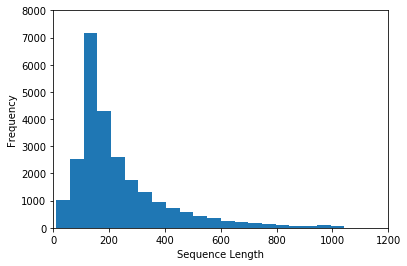

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

The histogram as well as the average number of words per file indicatethat most reviews will **fall under 250 words**, which is the **max sequence length** value we will set. 

In [10]:
maxSeqLength = 250

Take a file and transform it into ids matrix. 
Check accuracy using one of the reviews.

In [14]:
fname = positiveFiles[20] #any valid index <12500
with open(fname) as f:
    for lines in f:
        print(lines)
        exit

This film is worth seeing alone for Jared Harris' outstanding portrayal of John Lennon. It doesn't matter that Harris doesn't exactly resemble Lennon; his mannerisms, expressions, posture, accent and attitude are pure Lennon. Best scene: Lennon in a local cafe verbally sparring with a stuttering fan as to whether Paul McCartney & Wings' "Silly Love Songs" is worthy of #1 status in America.


Convert to an ids matrix

In [15]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [17]:
firstFile = np.zeros((maxSeqLength), dtype='int32')
with open(fname) as f:
    indexCounter = 0
    line=f.readline()
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
        if indexCounter < maxSeqLength:
            try:
                firstFile[indexCounter] = wordsList.index(word)
            except ValueError:
                firstFile[indexCounter] = 399999 #Vector for UNK
        indexCounter = indexCounter + 1
firstFile

array([    37,    319,     14,   1089,   2660,   1485,     10,  19073,
         3730,   3535,  12033,      3,    279,  11950,     20, 136283,
         1120,     12,   3730, 136283,   2796,  11045,  11950,     26,
        43501,  11482,  16304,  10983,      5,   4191,     32,   5744,
        11950,    254,   1500,  11950,      6,      7,    250,   6963,
        23474,  26553,     17,      7,  39262,   3267,     19,      4,
          401,    923,  11622,   4698,  10817,    835,   1499,     14,
         8600,      3,    176,   1416,      6,    453,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

Do the same for each of our 25,000 reviews.

In [ ]:
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
fileCounter = 0
for pf in positiveFiles:
   with open(pf, "r") as f:
       indexCounter = 0
       line=f.readline()
       cleanedLine = cleanSentences(line)
       split = cleanedLine.split()
       for word in split:
           try:
               ids[fileCounter][indexCounter] = wordsList.index(word)
           except ValueError:
               ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
           indexCounter = indexCounter + 1
           if indexCounter >= maxSeqLength:
               break
       fileCounter = fileCounter + 1 

for nf in negativeFiles:
   with open(nf, "r") as f:
       indexCounter = 0
       line=f.readline()
       cleanedLine = cleanSentences(line)
       split = cleanedLine.split()
       for word in split:
           try:
               ids[fileCounter][indexCounter] = wordsList.index(word)
           except ValueError:
               ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
           indexCounter = indexCounter + 1
           if indexCounter >= maxSeqLength:
               break
       fileCounter = fileCounter + 1 
#Pass into embedding function and see if it evaluates. 

np.save('idsMatrix', ids)

In [19]:
ids = np.load('idsMatrix.npy')

# decided to use pre-computed result after frustrating time of training the model...

# Helper Functions

In [20]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,11499)
            labels.append([1,0])
        else:
            num = randint(13499,24999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(11499,13499)
        if (num <= 12499):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

# RNN Model

In [35]:
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 100000
# adapted from online tutorials

In [36]:
import tensorflow as tf
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])
# placeholders

In [37]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

Feed this input into an LSTM network by calling the **tf.nn.rnn_cell.BasicLSTMCell function.**
Then, wrap that LSTM cell in a dropout layer (**tf.contrib.rnn.DropoutWrapper**)to help prevent the network from overfitting. 

Finally, feed both the LSTM cell and the 3-D tensor full of input data into function tf.nn.dynamic_rnn. 

In [38]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [39]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

Define the correct prediction and accuracy metrics to track how the network is doing.<br>
The correct prediction formulation works by looking at the index of the maximum value of the 2 output values, and then seeing whether it matches with the training labels. 

In [40]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

Define a standard cross entropy loss with a softmax layer put on top of the final prediction values.<br> 
Optimizer: Adam with learning rate alpha of .001. 

In [41]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

# Hyperparameter Tuning

Choosing the right values for your hyperparameters is a crucial part of training deep neural networks effectively. <br>
The hyperparameters used in this piece of code are very largely adapted form github tutorials
* **Learning Rate**: adapted from tutorials
* **Optimizer**: Adam has been widely popular.
* **Number of LSTM units**: adapted from tutorials (tried to modify a bit due to computation power)
* **Word Vector Size**: adapted from tutorials

# Loading a Pretrained Model

**Pretrained model**’s accuracy and loss curves during training can be found below. 

![caption](Images/SentimentAnalysis6.png)
![caption](Images/SentimentAnalysis7.png)

In [42]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

INFO:tensorflow:Restoring parameters from models/pretrained_lstm-90000.ckpt


Load some movie reviews from test set and test the accuracy 

In [53]:
iterations = 50
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Iteration ", i+1)
    print("Accuracy for this batch ",(sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Iteration  1
Accuracy for this batch  87.5
Iteration  2
Accuracy for this batch  75.0
Iteration  3
Accuracy for this batch  87.5
Iteration  4
Accuracy for this batch  87.5
Iteration  5
Accuracy for this batch  87.5
Iteration  6
Accuracy for this batch  79.16666865348816
Iteration  7
Accuracy for this batch  62.5
Iteration  8
Accuracy for this batch  87.5
Iteration  9
Accuracy for this batch  75.0
Iteration  10
Accuracy for this batch  95.83333134651184
Iteration  11
Accuracy for this batch  83.33333134651184
Iteration  12
Accuracy for this batch  91.66666865348816
Iteration  13
Accuracy for this batch  91.66666865348816
Iteration  14
Accuracy for this batch  87.5
Iteration  15
Accuracy for this batch  75.0
Iteration  16
Accuracy for this batch  87.5
Iteration  17
Accuracy for this batch  75.0
Iteration  18
Accuracy for this batch  75.0
Iteration  19
Accuracy for this batch  87.5
Iteration  20
Accuracy for this batch  91.66666865348816
Iteration  21
Accuracy for this batch  83.333331346

# Test with own data

In [56]:
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

def getSentenceMatrix(sentence):
    arr = np.zeros([batchSize, maxSeqLength])
    sentenceMatrix = np.zeros([batchSize,maxSeqLength], dtype='int32')
    cleanedSentence = cleanSentences(sentence)
    split = cleanedSentence.split()
    for indexCounter,word in enumerate(split):
        try:
            sentenceMatrix[0,indexCounter] = wordsList.index(word)
        except ValueError:
            sentenceMatrix[0,indexCounter] = 399999 #Vector for unkown words
    return sentenceMatrix

In [70]:
inputText = "my heart leaps up when i behold a rainbow"
inputMatrix = getSentenceMatrix(inputText)
predictedSentiment = sess.run(prediction, {input_data: inputMatrix})[0]

if (predictedSentiment[0] > predictedSentiment[1]):
    print ("Positive Sentiment")
else:
    print ("Negative Sentiment")

Positive Sentiment


In [69]:
secondInputText = "I should be telling this with a sigh, somewhere ages and ages hence" 
secondInputMatrix = getSentenceMatrix(secondInputText)
predictedSentiment = sess.run(prediction, {input_data: secondInputMatrix})[0]
if (predictedSentiment[0] > predictedSentiment[1]):
    print ("Positive Sentiment")
else:
    print ("Negative Sentiment")

Negative Sentiment
